# Demo 3: Beatles lyrics

In this demo we will train a decoder-only transformer on Beatles lyrics.

In [1]:
import os
import sys
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch
from torch.utils.data import DataLoader

# set to true if working in google colab
colab = False

if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    root_dir = '/content/drive/MyDrive/Projects/Transformer'
    sys.path.append(root_dir)
else:
    root_dir = os.getcwd()

# custom imports
from transformer import layers
from transformer.layers import Transformer
from transformer.nlp import Vocab, TokenizedDataset, InferenceSampler

# set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Device is {device}')

Device is cpu


## Data

We use the custom Vocab class to load the text corpus and initialize the vocabulary according to this corpus. 
We use a subword tokenization scheme in which we split the corpus at boundaries between word and non-word characters. 

A more sophisticated and commonly used subword tokenization scheme is Byte-Pair Encoding (BPE), in which the corpus is first fully split into individual characters, and then, iteratively, the most frequently adjacent pairs of characters are combined into a new token.

The Vocab class provides useful methods for converting strings to tokens and vice versa.

In [2]:
filepath = os.path.join(root_dir, 'data', 'beatles.txt')

# pattern matching boundary between word and non-word characters
pattern = r'\b'

vocab = Vocab(filepath, pattern)

print(f'vocab contains {len(vocab)} subwords.')

vocab contains 3013 subwords.


We can now use the vocab to tokenize the corpus, using the method `tokenize_from_file`:

In [3]:
corpus = vocab.tokenize_from_file(filepath)  # list
corpus = torch.tensor(corpus, dtype=torch.long, device=device)  # tensor

print(f'Length of corpus: {len(corpus)} tokens')

Length of corpus: 75515 tokens


Let's split our corpus so that 95% goes into the training set and 5% into the test set. We use the custom class TokenizedDataset to define the datasets. This class creates training examples consisting of (input, target) pairs, where input is the same token sequence as target but right shifted by one position.

We will use a context window of 128 tokens, which corresponds to roughly two verses of Beatles lyrics. 

In [4]:
context_window = 128
batch_size = 64

train_corpus = corpus[:round(0.95 * len(corpus))]
test_corpus = corpus[round(0.95 * len(corpus)):]

train_set = TokenizedDataset(train_corpus, context_window, device)
test_set = TokenizedDataset(test_corpus, context_window, device)

train_loader = DataLoader(train_set, batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size, shuffle=True)

print(f'Train loader: {len(train_loader)} batches of size {batch_size}')
print(f'Test loader: {len(test_loader)} batches of size {batch_size}')

Train loader: 1119 batches of size 64
Test loader: 57 batches of size 64


## Model

Next we define the decoder-only transformer using the custom Transformer class. It consists of the following layers:
- embedding and positional encoding
- decoder stack
- linear (de-embedding) layer

Each decoder in the decoder stack consists of a masked multihead attention layer followed by a position-wise fully connected two-layer feed forward neural network.

In [5]:
vocab_size = len(vocab) # number of words in vocab
d_model = 512 # size of internal representation of words
n_pe = 10000 # determines freq in positional encoding
num_heads = 8 # attention heads
num_stacks = 6 # decoder stacks
d_ff = d_model * 4 # hidden layer in FFNN
dropout = 0 # dropout probability

model = Transformer(
    vocab=vocab_size,
    n_pe=n_pe,
    d_model=d_model,
    num_heads=num_heads,
    num_stacks=num_stacks,
    d_ff=d_ff,
    dropout=dropout
).to(device)

Let's do a count of the number of learnable parameters in the model:

In [51]:
n_params = 0
# Embedding
n_params += vocab_size * d_model
# Attention
n_params += num_stacks * 4 * d_model**2
# FFNN weights
n_params += num_stacks * 2 * d_model * d_ff
# FFNN biases
n_params += num_stacks * (d_ff + d_model)
# De-embedding
n_params += d_model * vocab_size
# Layer normalization
n_params += (num_stacks * 2 + 1) * 2 * d_model

print(f'Total number of parameters is {n_params:,}.')

Total number of parameters is 21,988,352.


For reference this is about 5 times smaller than GPT-1, which has 117 million parameters.


Let's first see how the untrained model performs. To do this we first define a InferenceSampler object using the model and vocab. The custom InferenceSampler class provides methods for autoregressively generating outputs given a prompt, according to different sampling strategies.

In [43]:
sampler = InferenceSampler(model, vocab, context_window, device)

The sampler allows for three sampling methods: greedy sampling, top_p sampling (nucleus sampling), and beam search. 

For example, greedy sampling simply outputs the most probable next token, given the previous tokens. Let's use greedy sampling with the input prompt 'How many miles must a man walk down', and see what the untrained transformer output.

In [44]:
prompt = 'How many miles must a man walk down'
output = sampler.greedy(prompt, num_tokens=120)
print(output)

How many miles must a man walk downobrigadoloseElheldstickhoopsWonderingMeetoanfevercaratEggmenworseDeafpriestesstubesunnySomebodymanysadhelpsearthtrampolinemilitarycollapsedOohputLiftingheylogbringmournkeepsMoveWannalogbringmournTastingWerescreamingdiggingseesthankNabundleMarvelbringingOkayAnywaysinbringmournfoldstarspiecloserestlessSatisfactionphotographsphotographsfishwifesweetthankourselveslogbringquitquialoudovernight, 'gameneedJuliabeatbutdeepercheat, 
shadowOrphotographsMymilitaryarmymiseryChairmanOnodMarthasleepWouldWasanothersomebodyWithCharlesliedwingsmetthankNalaladifficultysameclubsNaKirkcaldyAnnaBrightsomethingBrightsomethingBrightsomethingBangdealprouddancer


Unsurprisingly the untrained transformer's output doesn't make any sense.

## Training

Now let's define the testing and training loops. We will use a custom cross entropy loss function and an Adam optimizer. 

For simplicity we will just train the model until the loss drops below a prescribed threshold (0.5). As we will see this will overfit the model.

In [9]:
cost_fn = layers.CrossEntropyLoss(swap_dims=True)
optim = torch.optim.Adam(model.parameters(), lr=6e-4)

def test(model, num_batches):
    """Tests model on num_batches from the test set."""
    model.eval()
    with torch.no_grad():
        total_loss = 0
        batch = 0
        for input, target in test_loader:
            if batch >= num_batches: break
            output = model(input)
            total_loss += cost_fn(output, target)
            batch += 1

    model.train()

    # return average loss
    return total_loss.item() / num_batches

def train(model, threshold):
    """Trains a model until the training loss falls below threshold"""

    train_losses = []
    test_losses = []

    batch = 0
    loss = float('inf')

    def save(model, batch):
        """Function for saving the model's parameters."""
        path = os.path.join(root_dir, 'checkpoints', f'batch{batch}.pt')
        torch.save(model.state_dict(), path)

    while True:

        for input, target in train_loader:

            if loss < threshold:
                save(model, batch)
                return train_losses, test_losses

            # output
            output = model(input)

            # loss
            loss = cost_fn(output, target)
            train_losses.append((batch, loss.item()))

            # backprop
            optim.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

            # step
            optim.step()

            # test
            if batch % 10 == 0:
                test_loss = test(model, 1)
                test_losses.append((batch, test_loss))

            # save checkpoint
            if batch % 50 == 0:
                save(model, batch)

            # print progress
            clear_output(wait=True)
            print(f'Batch {batch}: Loss = {loss.item():.3}')

            batch += 1

train_losses, test_losses = train(model)

Batch 215: Loss = 0.477


Let's plot the training and test losses:

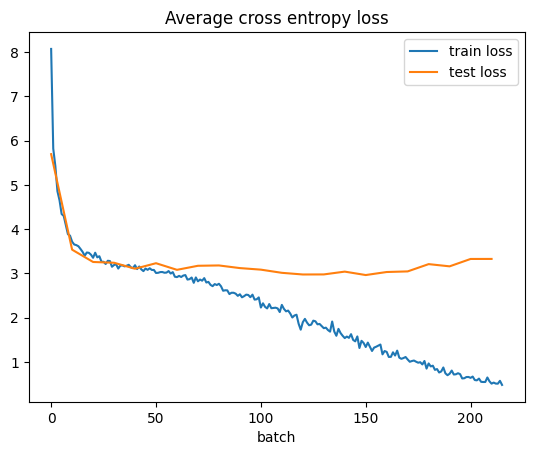

In [10]:
fig, ax = plt.subplots()

# train loss
x, y = zip(*train_losses)
ax.plot(x, y, label='train loss')

# test loss
x, y = zip(*test_losses)
ax.plot(x, y, label='test loss')

ax.set_xlabel('batch')
ax.set_title('Average cross entropy loss')
ax.legend()
plt.show()

The widening gap between the training and test losses is a telltale sign of overfitting. 

Notice that the model starts overfitting at roughly batch 50, while the training set contains 1119 batches. This might seem surprising, but it makes sense when we recall that the 1119 batches in our training set contain significant overlap, due to the way we defined the individual training sequences, i.e. a different sequence starting at each position in the corpus. 

Removing these overlapping sequences would likely prevent overfitting until at least one full pass through the training set is made. However in this case our training set would be smaller by a factor of 128 (the context window), so one full pass through the training set would correspond to only ~10 batches (assuming the batch size is kept the same). Thus it seems likely that this would not in fact allow us to train the model for longer before we run into overfitting. Regularization techniques (e.g. dropout, weight decay, label smoothing, etc.) might improve generalization, but to get significant improvements we would probably simply need more data.

Finally, we note that to obtain a model which hasn't overfit, we could simply reset the model's parameters to those in checkpoint file 'batch50.pt', corresponding to the model's state after batch 50. However this model doesn't produce very coherent outputs, so to illustrate inference we will use the overfitted model.

## Inference

In [6]:
# Reload model and sampler using last checkpoint file
model = Transformer(
    vocab=vocab_size,
    n_pe=n_pe,
    d_model=d_model,
    num_heads=num_heads,
    num_stacks=num_stacks,
    d_ff=d_ff,
    dropout=dropout
).to(device)

model_path = os.path.join(root_dir, 'checkpoints', 'batch216.pt')

model.load_state_dict(torch.load(model_path, map_location=device))

sampler = InferenceSampler(model, vocab, context_window, device)

Let's consider the same prompt that we used before, 'How many miles must a man walk down', and see what the model now outputs. Again we will use greedy inference:

In [7]:
prompt = 'How many miles must a man walk down'
output = sampler.greedy(prompt, num_tokens=120)
print(output)

How many miles must a man walk down
The was waiting for a lover, you
The was waiting for you

And your bird is love you
And you need is it's true
It's me

Please be don't be long
Please don't be long
Please don't be long
Please don't be long
Please don't be long
Please don't don't don


This is clearly a huge step up from before training, but it still doesn't make much sense. And in the parts where it does make sense ("Please don't be long"), the model is simply repeating verbatim text from the training data (from the chorus of the song Blue Jay Way). This is consistent with our earlier conclusion that the model is overfitted.

Now instead of using greedy sampling let's use top_p sampling with p=0.7. In this case, at each position the outputs are sorts by descending probability, and we sample from the smallest number of outputs with a cumulative probability greater than p.

In [9]:
output = sampler.top_p(prompt, num_tokens=120, p=0.7)
print(output)

How many miles must a man walk down belle
First do the that be in blue 
Will you leave me know, oh-oh, oh, oh what it's like to be better
So , no could to stay can't be long
Make love singing songs

Well, please some some come on
If you near away
I got just to do make you hand
Oh, yeah
(Lo-o 


The model is now more creative and isn't simply repeating the training text, because we are potentially allowing it to output tokens other than the most likely token. Unfortunately though it also less coherent. The sentences don't even make grammatical sense anymore.

Now let's try using beam search inference. In this sampling technique we keep track of the most probable sequences of tokens, or "beams", and at the end we output the beam with the highest probability. The beam width parameter controls how many beams we consider. If the beam width were large enough, we would consider all possible output sequences, and we would end up outputting the sequence which maximizes the likelihood. However this would require keeping track of ${\text{(vocab size)}}^{\text{(num tokens)}}$ beams, which is about $10^{42}$ in our case, and therefore infeasible. Instead we will consider a beam width of 10, which is actually a fairly standard value used in beam search inference (even a beam width of 2 is often useful).

In [29]:
output = sampler.beam_search(prompt, num_tokens=120, width=10)
print(output)

How many miles must a man walk down
The was waiting for this moment to arise
(Two, three)

Yes, I'm lonely
Wanna die
Yes, I'm lonely
Wanna die
If I ain't dead already, whoo
Girl, you know the reason reason why

In the morning
Wanna die
In the evening
Wanna die
If I ain't dead already, whoo
Girl, you know know know know know


The output is certainly more coherent than with top_p sampling, but once again the model is simply repeating text from the training data (see song Yer Blues). This is generally the tradeoff: beam search is more coherent but less creative than top_p sampling.

To get a more creative output using beam search we can increase the temperature parameter, which effectively flattens out the probability distributions of the outputs.

In [15]:
output = sampler.beam_search(prompt, num_tokens=120, temp=100, width=10)
print(output)

How many miles must a man walk down
The was waiting waiting for a trim
And then the fireman rushes in
From the pouring rain

Penny Lane is in my ears and in my eyes
There beneath the blue suburban skies
I sit and meanwhile back

Penny Lane is in my ears and in my eyes
There beneath the blue suburban skies
I sit sit sit sit sit


This doesn't really make the output more creative - the model is still repeating what it has seen during training.

To conclude, with our model it doesn't seem possible to get output that is both coherent *and* original. This is not very surprising, since our data consisted of only 75 thousand tokens. To get satisfactory performance we would need signficantly more data. For example, GPT-1, which has a model size roughly 5 times larger than our model, used a training set containing approximately 600 billion words (so roughly the same number of tokens) which is 10 million times larger than our training set. With more data comes more capability.